In [1]:
import sys
sys.path.append('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/00_Codes/sleepyspike')
import sleepyspike.sleepscoring as slpysc
import sleepyspike.lfpanalysis as slpylfp
import sleepyspike.reactivation as slpyreact
import sleepyspike.lfpspike as slpylfpspike

import os
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.io
from scipy import signal, stats
from scipy.fftpack import fft
from scipy.stats import t, sem, zscore
from scipy.signal import butter, lfilter, filtfilt, hilbert
import pandas as pd
import pickle
import matplotlib as mpl

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
metainfo_list = glob.glob('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/TM*/*_smp*/metainfo.h5')

In [3]:
session_info = []
for i in range(len(metainfo_list)):
    metainfo = h5py.File(metainfo_list[i], 'r')
    session_info.append(metainfo['general/mouseID'].value)
    session_info.append(metainfo_list[i].replace('/metainfo.h5',''))
    session_info.append(metainfo['general/sessionNo'].value)
    session_info.append(metainfo['general/sessionType'].value)
    session_info.append(metainfo['general/condition'].value)
    metainfo.flush()
    metainfo.close()

session_info = pd.DataFrame(np.array(session_info).reshape((int(len(session_info)/5),5)), columns=['mouseID','sessionDir','sessionNo','sessionType','condition'])
session_info.set_index('mouseID', inplace=True)
display(session_info)

,sessionDir,sessionNo,sessionType,condition
mouseID,,,,
TM015,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session11,sampling,w/ female
TM016,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session18,sampling,w/o female
TM018,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session07,sampling,w/ female
TM019,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session08,sampling,w/o female
TM020,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session04,sampling,w/ female
TM022,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session05,sampling,w/o female
TM023,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session03,sampling,w/o female
TM025,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session03,sampling,w/ female
TM027,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session05,sampling,w/o female


In [4]:
classified_unit =  pd.read_csv('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/Analysis_all/01_UnitProcess/unit_features_all.csv')
classified_unit

,Unnamed: 0,unitID,firing_rate,isi_violation,snr,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope,channel,region,mouseID,location,quality,type
0,0,35,2.237074,0.044873,11.463259,0.000900,0.000233,-0.180802,218979.079818,-20143.828236,47,M2,TM015,True,single,RS
1,1,37,2.197526,0.012682,14.089093,0.000833,0.000267,-0.248801,374312.617044,-51907.822041,9,M2,TM015,True,single,RS
2,2,41,1.679880,0.050640,16.874872,0.000900,0.000267,-0.225203,437182.905394,-51847.973820,11,M2,TM015,True,single,RS
3,3,43,1.484802,0.074080,7.368224,0.000833,0.000300,-0.269797,224905.226265,-28067.580250,13,M2,TM015,True,single,RS
4,4,45,1.486497,0.120106,14.856447,0.000800,0.000267,-0.233895,495306.454355,-46767.035923,13,M2,TM015,True,single,RS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,376,59,0.401093,0.127662,8.880773,0.000667,0.000167,-0.157995,187209.381290,-19010.246409,4,BLA,TM039,True,single,RS
377,377,61,1.392340,0.169505,13.290903,0.000667,0.000233,-0.244651,332690.339876,-42950.134670,5,BLA,TM039,True,single,RS
378,378,65,1.952030,0.000000,20.369117,0.000633,0.000167,-0.131489,563334.035695,-34132.010154,4,BLA,TM039,True,single,RS
379,379,70,0.057273,0.000000,9.460218,0.000767,0.000267,-0.212500,181975.300685,-25325.379411,8,BLA,TM039,True,single,RS


In [5]:
mouse_list_good=[]
for i in session_info.index:
    if len(np.array(classified_unit[classified_unit['mouseID']==i][classified_unit['region']=='BLA'][classified_unit['location']==True]))!=0:
        mouse_list_good.append(i)

mouseID_wf = []
mouseID_wof = []
for i in mouse_list_good:
    if session_info.loc[i]['condition'] == 'w/ female':
        mouseID_wf.append(i)
    else:
        mouseID_wof.append(i)
mouseID_wf = np.array(mouseID_wf)
mouseID_wof = np.array(mouseID_wof)
print('mouseIDs:',mouse_list_good)
print('w/ female condition:',mouseID_wf)
print('w/o female condition:',mouseID_wof)

mouseIDs: ['TM015', 'TM019', 'TM020', 'TM023', 'TM025', 'TM027', 'TM028', 'TM029', 'TM033', 'TM035', 'TM037', 'TM038', 'TM039']
w/ female condition: ['TM015' 'TM020' 'TM025' 'TM028' 'TM033' 'TM037']
w/o female condition: ['TM019' 'TM023' 'TM027' 'TM029' 'TM035' 'TM038' 'TM039']


In [6]:
mouse_list_good

['TM015',
 'TM019',
 'TM020',
 'TM023',
 'TM025',
 'TM027',
 'TM028',
 'TM029',
 'TM033',
 'TM035',
 'TM037',
 'TM038',
 'TM039']

In [7]:
def binrasterLoad(mouseID, region, binraster_Dir, unitType):
    with open(binraster_Dir+ '/'+mouseID+'_binraster.pkl', 'rb') as f:
        binraster_ =  pickle.load(f)
        binraster_RS = {}
        if binraster_[region +'_RS'] != []:
            nonfiring_id = np.where(np.sum(np.array(list(binraster_[region +'_RS']['Task'].values())),axis=1)==0)[0]
            for i in binraster_[region +'_RS'].keys():
                tmp = {i: np.delete(np.array(list(binraster_[region +'_RS'][i].values())), nonfiring_id, axis=0)}
                binraster_RS.update(tmp)
            #binraster=binraster_RS
            print(mouseID,region +'_RS', binraster_RS['Task'].shape[0])
        else:
            print(mouseID,region +'_RS', 'No units')
            #binraster = []
        binraster_FS = {}        
        if binraster_[region +'_FS'] != []:
            nonfiring_id = np.where(np.sum(np.array(list(binraster_[region +'_FS']['Task'].values())),axis=1)==0)[0]
            for i in binraster_[region +'_FS'].keys():
                tmp = {i: np.delete(np.array(list(binraster_[region +'_FS'][i].values())), nonfiring_id, axis=0)}
                binraster_FS.update(tmp)
            print(mouseID,region +'_FS', binraster_FS['Task'].shape[0])
        else:
            print(mouseID,region +'_FS', 'No units')

        if (binraster_RS != {}) & (binraster_FS != {}):
            if unitType == 'RS':
                binraster=binraster_RS
            elif unitType == 'FS':
                binraster=binraster_FS
            else:
                binraster = {}
                for i in binraster_RS.keys():
                    tmp = {i: np.vstack([binraster_RS[i],binraster_FS[i]])}
                    binraster.update(tmp)      
        elif (binraster_RS != {}) & (binraster_FS == {}):
            if unitType == 'FS':
                binraster = []
                print(mouseID,region +'_FS', 'No units')
            else:
                binraster = binraster_RS
        elif (binraster_RS == {}) & (binraster_FS != {}):
            if unitType == 'RS':
                binraster = []
                print(mouseID,region +'_RS', 'No units')
            else:
                binraster = binraster_FS
        else:
            binraster = []
            print('No '+region+ ' units')
    
    return binraster

In [8]:
def stateFrRate(binraster, epoch_state, binwidth):
    firingRate = []
    for i in range(binraster[epoch_state].shape[0]):
        if epoch_state=='POST_NREM':
            spNum_tmp = np.sum(binraster[epoch_state][:,:int(3600/binwidth)][i])
            firingRate_tmp = spNum_tmp/(binraster[epoch_state][:,:int(3600/binwidth)].shape[1]*binwidth)
            firingRate.append(firingRate_tmp)
        else:
            spNum_tmp = np.sum(binraster[epoch_state][i])
            firingRate_tmp = spNum_tmp/(binraster[epoch_state].shape[1]*binwidth)
            firingRate.append(firingRate_tmp)
    # firingRate=np.array(firingRate)

    return firingRate

In [9]:
binwidth = 0.025
binraster_Dir = glob.glob('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/Analysis_All/01_UnitProcess/binraster_'+str(int(binwidth*1000))+'ms')[0]

In [10]:
def stateFrRate_all(mouseID_list, binwidth, unitType):
    BLA_fr_task_all = []
    BLA_fr_postNREM_all = []
    BLA_fr_postREM_all = []
    M2_fr_task_all = []
    M2_fr_postNREM_all = []
    M2_fr_postREM_all = []
    S1_fr_task_all = []
    S1_fr_postNREM_all = []
    S1_fr_postREM_all = []
    for mouseID in mouseID_list:
        binraster_BLA = binrasterLoad(mouseID = mouseID, region = 'BLA', binraster_Dir=binraster_Dir, unitType=unitType)
        binraster_M2 = binrasterLoad(mouseID = mouseID, region = 'M2', binraster_Dir=binraster_Dir, unitType=unitType)
        binraster_S1 = binrasterLoad(mouseID = mouseID, region = 'S1', binraster_Dir=binraster_Dir, unitType=unitType)
        if binraster_BLA != []:
            BLA_fr_task = stateFrRate(binraster_BLA, 'Task', binwidth=binwidth)
            BLA_fr_postNREM = stateFrRate(binraster_BLA, 'POST_NREM', binwidth=binwidth)
            BLA_fr_postREM = stateFrRate(binraster_BLA, 'POST_REM', binwidth=binwidth)
            BLA_fr_task_all.extend(BLA_fr_task)
            BLA_fr_postNREM_all.extend(BLA_fr_postNREM)
            BLA_fr_postREM_all.extend(BLA_fr_postREM)

        if binraster_M2 != []:
            M2_fr_task = stateFrRate(binraster_M2, 'Task', binwidth=binwidth)
            M2_fr_postNREM = stateFrRate(binraster_M2, 'POST_NREM', binwidth=binwidth)
            M2_fr_postREM = stateFrRate(binraster_M2, 'POST_REM', binwidth=binwidth)
            M2_fr_task_all.extend(M2_fr_task)
            M2_fr_postNREM_all.extend(M2_fr_postNREM)
            M2_fr_postREM_all.extend(M2_fr_postREM)

        if binraster_S1 != []:
            S1_fr_task = stateFrRate(binraster_S1, 'Task', binwidth=binwidth)
            S1_fr_postNREM = stateFrRate(binraster_S1, 'POST_NREM', binwidth=binwidth)
            S1_fr_postREM = stateFrRate(binraster_S1, 'POST_REM', binwidth=binwidth)
            S1_fr_task_all.extend(S1_fr_task)
            S1_fr_postNREM_all.extend(S1_fr_postNREM)
            S1_fr_postREM_all.extend(S1_fr_postREM)
    
    BLA_fr_task_all = np.array(BLA_fr_task_all)
    BLA_fr_postNREM_all = np.array(BLA_fr_postNREM_all)
    BLA_fr_postREM_all = np.array(BLA_fr_postREM_all)
    M2_fr_task_all = np.array(M2_fr_task_all)
    M2_fr_postNREM_all = np.array(M2_fr_postNREM_all)
    M2_fr_postREM_all = np.array(M2_fr_postREM_all)
    S1_fr_task_all = np.array(S1_fr_task_all)
    S1_fr_postNREM_all = np.array(S1_fr_postNREM_all)
    S1_fr_postREM_all = np.array(S1_fr_postREM_all)

    state_FR_all = {'BLA_task':BLA_fr_task_all, 'BLA_POST_NREM':BLA_fr_postNREM_all, 'BLA_POST_REM':BLA_fr_postREM_all, 
                    'M2_task':M2_fr_task_all, 'M2_POST_NREM':M2_fr_postNREM_all, 'M2_POST_REM':M2_fr_postREM_all, 
                    'S1_task':S1_fr_task_all, 'S1_POST_NREM':S1_fr_postNREM_all, 'S1_POST_REM':S1_fr_postREM_all}
    
    return state_FR_all

In [34]:
state_FR_w = stateFrRate_all(mouseID_list=mouseID_wf, binwidth=binwidth, unitType='RS')
state_FR_wo = stateFrRate_all(mouseID_list=mouseID_wof, binwidth=binwidth, unitType='RS')

TM015 BLA_RS 25
TM015 BLA_FS No units
TM015 M2_RS 8
TM015 M2_FS No units
TM015 S1_RS 10
TM015 S1_FS 1
TM020 BLA_RS 7
TM020 BLA_FS No units
TM020 M2_RS 2
TM020 M2_FS No units
TM020 S1_RS 11
TM020 S1_FS 1
TM025 BLA_RS 6
TM025 BLA_FS No units
TM025 M2_RS No units
TM025 M2_FS No units
No M2 units
TM025 S1_RS No units
TM025 S1_FS No units
No S1 units
TM028 BLA_RS 8
TM028 BLA_FS No units
TM028 M2_RS 4
TM028 M2_FS 2
TM028 S1_RS 11
TM028 S1_FS 1
TM033 BLA_RS 5
TM033 BLA_FS 1
TM033 M2_RS 11
TM033 M2_FS 1
TM033 S1_RS 4
TM033 S1_FS No units
TM037 BLA_RS 5
TM037 BLA_FS 1
TM037 M2_RS 20
TM037 M2_FS No units
TM037 S1_RS 13
TM037 S1_FS 3
TM019 BLA_RS 14
TM019 BLA_FS 2
TM019 M2_RS No units
TM019 M2_FS No units
No M2 units
TM019 S1_RS 1
TM019 S1_FS 4
TM023 BLA_RS 7
TM023 BLA_FS No units
TM023 M2_RS No units
TM023 M2_FS No units
No M2 units
TM023 S1_RS No units
TM023 S1_FS 1
TM023 S1_RS No units
TM027 BLA_RS 2
TM027 BLA_FS 1
TM027 M2_RS 12
TM027 M2_FS No units
TM027 S1_RS 1
TM027 S1_FS 1
TM029 BLA_RS 14

In [36]:
def calc_FR_Ratio(state_FR, epoch_state_1,epoch_state_2):
    FR_ratio = (state_FR[epoch_state_1]-state_FR[epoch_state_2])/(state_FR[epoch_state_1]+state_FR[epoch_state_2])

    return FR_ratio

In [37]:
def calc_hist_weights(data):
    weights = np.ones(len(data))/len(data)
    return weights

In [38]:
BLA_FR_ratio_NREM_wo = calc_FR_Ratio(state_FR_wo, 'BLA_POST_NREM', 'BLA_task')
BLA_FR_ratio_NREM_w = calc_FR_Ratio(state_FR_w, 'BLA_POST_NREM', 'BLA_task')
BLA_FR_ratio_REM_wo = calc_FR_Ratio(state_FR_wo, 'BLA_POST_REM', 'BLA_task')
BLA_FR_ratio_REM_w = calc_FR_Ratio(state_FR_w, 'BLA_POST_REM', 'BLA_task')
BLA_FR_ratio_NREMREM_wo = calc_FR_Ratio(state_FR_wo, 'BLA_POST_REM', 'BLA_POST_NREM')
BLA_FR_ratio_NREMREM_w = calc_FR_Ratio(state_FR_w, 'BLA_POST_REM', 'BLA_POST_NREM')

M2_FR_ratio_NREM_wo = calc_FR_Ratio(state_FR_wo, 'M2_POST_NREM', 'M2_task')
M2_FR_ratio_NREM_w = calc_FR_Ratio(state_FR_w, 'M2_POST_NREM', 'M2_task')
M2_FR_ratio_REM_wo = calc_FR_Ratio(state_FR_wo, 'M2_POST_REM', 'M2_task')
M2_FR_ratio_REM_w = calc_FR_Ratio(state_FR_w, 'M2_POST_REM', 'M2_task')
M2_FR_ratio_NREMREM_wo = calc_FR_Ratio(state_FR_wo, 'M2_POST_REM', 'M2_POST_NREM')
M2_FR_ratio_NREMREM_w = calc_FR_Ratio(state_FR_w, 'M2_POST_REM', 'M2_POST_NREM')

S1_FR_ratio_NREM_wo = calc_FR_Ratio(state_FR_wo, 'S1_POST_NREM', 'S1_task')
S1_FR_ratio_NREM_w = calc_FR_Ratio(state_FR_w, 'S1_POST_NREM', 'S1_task')
S1_FR_ratio_REM_wo = calc_FR_Ratio(state_FR_wo, 'S1_POST_REM', 'S1_task')
S1_FR_ratio_REM_w = calc_FR_Ratio(state_FR_w, 'S1_POST_REM', 'S1_task')
S1_FR_ratio_NREMREM_wo = calc_FR_Ratio(state_FR_wo, 'S1_POST_REM', 'S1_POST_NREM')
S1_FR_ratio_NREMREM_w = calc_FR_Ratio(state_FR_w, 'S1_POST_REM', 'S1_POST_NREM')

In [39]:
BLA_FR_ratio_NREM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':BLA_FR_ratio_NREM_wo})
BLA_FR_ratio_NREM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':BLA_FR_ratio_NREM_w})
BLA_FR_ratio_NREM =pd.concat([BLA_FR_ratio_NREM_wo_DF,BLA_FR_ratio_NREM_w_DF])
M2_FR_ratio_NREM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':M2_FR_ratio_NREM_wo})
M2_FR_ratio_NREM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':M2_FR_ratio_NREM_w})
M2_FR_ratio_NREM =pd.concat([M2_FR_ratio_NREM_wo_DF,M2_FR_ratio_NREM_w_DF])
S1_FR_ratio_NREM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':S1_FR_ratio_NREM_wo})
S1_FR_ratio_NREM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':S1_FR_ratio_NREM_w})
S1_FR_ratio_NREM =pd.concat([S1_FR_ratio_NREM_wo_DF,S1_FR_ratio_NREM_w_DF])

print(stats.ks_2samp(BLA_FR_ratio_NREM_wo,BLA_FR_ratio_NREM_w))
print(stats.ks_2samp(M2_FR_ratio_NREM_wo,M2_FR_ratio_NREM_w))
print(stats.ks_2samp(S1_FR_ratio_NREM_wo,S1_FR_ratio_NREM_w))

KstestResult(statistic=0.185, pvalue=0.28042134251787765)
KstestResult(statistic=0.23333333333333334, pvalue=0.25395575579476326)
KstestResult(statistic=0.19510204081632654, pvalue=0.47152382072352705)


In [40]:
BLA_FR_ratio_REM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':BLA_FR_ratio_REM_wo})
BLA_FR_ratio_REM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':BLA_FR_ratio_REM_w})
BLA_FR_ratio_REM =pd.concat([BLA_FR_ratio_REM_wo_DF,BLA_FR_ratio_REM_w_DF])
M2_FR_ratio_REM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':M2_FR_ratio_REM_wo})
M2_FR_ratio_REM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':M2_FR_ratio_REM_w})
M2_FR_ratio_REM =pd.concat([M2_FR_ratio_REM_wo_DF,M2_FR_ratio_REM_w_DF])
S1_FR_ratio_REM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':S1_FR_ratio_REM_wo})
S1_FR_ratio_REM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':S1_FR_ratio_REM_w})
S1_FR_ratio_REM =pd.concat([S1_FR_ratio_REM_wo_DF,S1_FR_ratio_REM_w_DF])

print(stats.ks_2samp(BLA_FR_ratio_REM_wo,BLA_FR_ratio_REM_w))
print(stats.ks_2samp(M2_FR_ratio_REM_wo,M2_FR_ratio_REM_w))
print(stats.ks_2samp(S1_FR_ratio_REM_wo,S1_FR_ratio_REM_w))

KstestResult(statistic=0.18071428571428572, pvalue=0.3053130202556207)
KstestResult(statistic=0.25555555555555554, pvalue=0.16965853204209058)
KstestResult(statistic=0.20489795918367346, pvalue=0.43197628893808626)


In [41]:
BLA_FR_ratio_NREMREM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':BLA_FR_ratio_NREMREM_wo})
BLA_FR_ratio_NREMREM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':BLA_FR_ratio_NREMREM_w})
BLA_FR_ratio_NREMREM =pd.concat([BLA_FR_ratio_NREMREM_wo_DF,BLA_FR_ratio_NREMREM_w_DF])
M2_FR_ratio_NREMREM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':M2_FR_ratio_NREMREM_wo})
M2_FR_ratio_NREMREM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':M2_FR_ratio_NREMREM_w})
M2_FR_ratio_NREMREM =pd.concat([M2_FR_ratio_NREMREM_wo_DF,M2_FR_ratio_NREMREM_w_DF])
S1_FR_ratio_NREMREM_wo_DF = pd.DataFrame(data={'condition':'w/o female','FR_ratio':S1_FR_ratio_NREMREM_wo})
S1_FR_ratio_NREMREM_w_DF = pd.DataFrame(data={'condition':'w/ female','FR_ratio':S1_FR_ratio_NREMREM_w})
S1_FR_ratio_NREMREM =pd.concat([S1_FR_ratio_NREMREM_wo_DF,S1_FR_ratio_NREMREM_w_DF])

print(stats.ks_2samp(BLA_FR_ratio_NREMREM_wo,BLA_FR_ratio_NREMREM_w))
print(stats.ks_2samp(M2_FR_ratio_NREMREM_wo,M2_FR_ratio_NREMREM_w))
print(stats.ks_2samp(S1_FR_ratio_NREMREM_wo,S1_FR_ratio_NREMREM_w))

KstestResult(statistic=0.12142857142857143, pvalue=0.7733990050009725)
KstestResult(statistic=0.24444444444444444, pvalue=0.2086820884074777)
KstestResult(statistic=0.20489795918367346, pvalue=0.43197628893808626)


In [42]:
print('BLA neuron number w/o Female:', BLA_FR_ratio_NREMREM_wo_DF.shape[0])
print('BLA neuron number w/ Female:', BLA_FR_ratio_NREMREM_w_DF.shape[0])
print('M2 neuron number w/o Female:', M2_FR_ratio_NREMREM_wo_DF.shape[0])
print('M2 neuron number w/ Female:', M2_FR_ratio_NREMREM_w_DF.shape[0])
print('S1 neuron number w/o Female:', S1_FR_ratio_NREMREM_wo_DF.shape[0])
print('S1 neuron number w/ Female:', S1_FR_ratio_NREMREM_w_DF.shape[0])

BLA neuron number w/o Female: 50
BLA neuron number w/ Female: 56
M2 neuron number w/o Female: 30
M2 neuron number w/ Female: 45
S1 neuron number w/o Female: 25
S1 neuron number w/ Female: 49


In [43]:
res_Dir = os.getcwd()+'/Results'
os.makedirs(res_Dir, exist_ok=True)

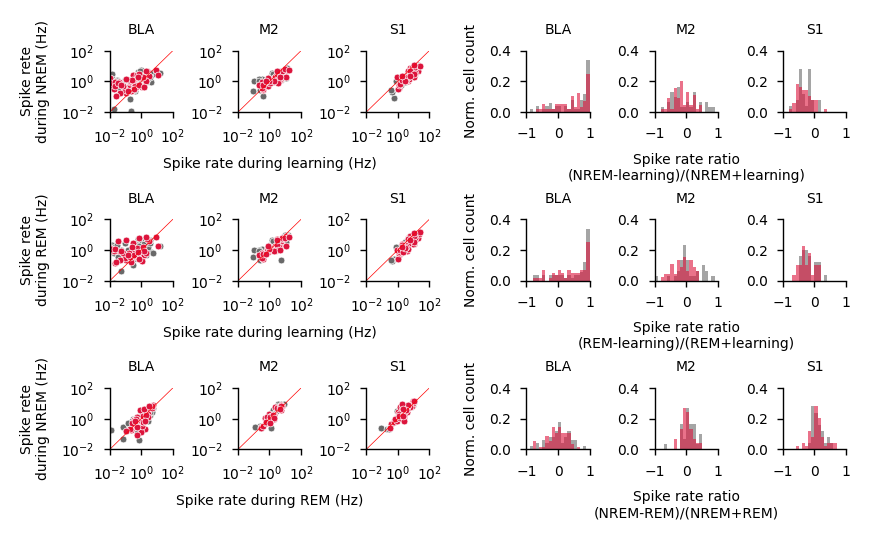

In [52]:
colors=['dimgray','crimson']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.minor.visible'] =False
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['axes.edgecolor']='black'
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.labelsize']=5
mpl.rcParams['axes.titlesize']=5
mpl.rcParams['legend.fontsize']=5
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['ytick.labelsize']=5
mpl.rcParams['text.color']='black'
mpl.rcParams['lines.color']='black'
mpl.rcParams['xtick.color']='black'
mpl.rcParams['ytick.color']='black'
mpl.rcParams['axes.labelcolor']='black'

x = np.arange(0,1000,1) #diagonal line
range_bin_width = np.array([x for x in range(-10,11,1)])/10
alpha=0.6

# plot task vs NREM
fig = plt.figure(figsize=(4.75,4.75),tight_layout=True)
sns.set_palette(colors)
gs = fig.add_gridspec(115, 115)

ax1 = fig.add_subplot(gs[0:10, 0:10])
plt1 = sns.scatterplot(state_FR_wo['BLA_task'],state_FR_wo['BLA_POST_NREM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
plt2 = sns.scatterplot(state_FR_w['BLA_task'],state_FR_w['BLA_POST_NREM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('BLA')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# plt.legend(labels=["w/o female", "w/ female"], loc='upper right', bbox_to_anchor=(0.5, 0.15, 0.5, 1),frameon=False)
plt.ylabel('Spike rete\nduring NREM (Hz)')

ax2 = fig.add_subplot(gs[0:10, 65:75])
sns.distplot(BLA_FR_ratio_NREM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(BLA_FR_ratio_NREM_wo), 'alpha':alpha}, kde=False)
sns.distplot(BLA_FR_ratio_NREM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(BLA_FR_ratio_NREM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('BLA')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# plt.xlabel('Firing rate ratio')
plt.ylabel('Norm. cell count')

ax3 = fig.add_subplot(gs[0:10, 20:30])
sns.scatterplot(state_FR_wo['M2_task'],state_FR_wo['M2_POST_NREM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['M2_task'],state_FR_w['M2_POST_NREM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('M2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Spike rate during learning (Hz)')

ax4 = fig.add_subplot(gs[0:10, 85:95])
sns.distplot(M2_FR_ratio_NREM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(M2_FR_ratio_NREM_wo), 'alpha':alpha}, kde=False)
sns.distplot(M2_FR_ratio_NREM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(M2_FR_ratio_NREM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('M2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Spike rate ratio\n(NREM-learning)/(NREM+learning)')

ax5 = fig.add_subplot(gs[0:10, 40:50])
sns.scatterplot(state_FR_wo['S1_task'],state_FR_wo['S1_POST_NREM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['S1_task'],state_FR_w['S1_POST_NREM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('S1')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

ax6 = fig.add_subplot(gs[0:10, 105:115])
sns.distplot(S1_FR_ratio_NREM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(S1_FR_ratio_NREM_wo), 'alpha':alpha}, kde=False)
sns.distplot(S1_FR_ratio_NREM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(S1_FR_ratio_NREM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('S1')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

ax1 = fig.add_subplot(gs[27:37, 0:10])
sns.scatterplot(state_FR_wo['BLA_task'],state_FR_wo['BLA_POST_REM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['BLA_task'],state_FR_w['BLA_POST_REM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('BLA')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
#plt.xlabel('Task (Hz)')
plt.ylabel('Spike rete\nduring REM (Hz)')

ax2 = fig.add_subplot(gs[27:37, 65:75])
sns.distplot(BLA_FR_ratio_REM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(BLA_FR_ratio_REM_wo), 'alpha':alpha}, kde=False)
sns.distplot(BLA_FR_ratio_REM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(BLA_FR_ratio_REM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('BLA')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# plt.xlabel('Firing rate ratio')
plt.ylabel('Norm. cell count')

ax3 = fig.add_subplot(gs[27:37, 20:30])
sns.scatterplot(state_FR_wo['M2_task'],state_FR_wo['M2_POST_REM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['M2_task'],state_FR_w['M2_POST_REM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('M2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Spike rate during learning (Hz)')

ax4 = fig.add_subplot(gs[27:37, 85:95])
sns.distplot(M2_FR_ratio_REM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(M2_FR_ratio_REM_wo), 'alpha':alpha}, kde=False)
sns.distplot(M2_FR_ratio_REM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(M2_FR_ratio_REM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('M2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Spike rate ratio\n(REM-learning)/(REM+learning)')

ax5 = fig.add_subplot(gs[27:37, 40:50])
sns.scatterplot(state_FR_wo['S1_task'],state_FR_wo['S1_POST_REM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['S1_task'],state_FR_w['S1_POST_REM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('S1')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

ax6 = fig.add_subplot(gs[27:37, 105:115])
sns.distplot(S1_FR_ratio_REM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(S1_FR_ratio_REM_wo), 'alpha':alpha}, kde=False)
sns.distplot(S1_FR_ratio_REM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(S1_FR_ratio_REM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('S1')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

ax1 = fig.add_subplot(gs[54:64, 0:10])
sns.scatterplot(state_FR_wo['BLA_POST_NREM'],state_FR_wo['BLA_POST_REM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['BLA_POST_NREM'],state_FR_w['BLA_POST_REM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('BLA')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
#plt.xlabel('Task (Hz)')
plt.ylabel('Spike rete\nduring NREM (Hz)')

ax2 = fig.add_subplot(gs[54:64, 65:75])
sns.distplot(BLA_FR_ratio_NREMREM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(BLA_FR_ratio_NREMREM_wo), 'alpha':alpha}, kde=False)
sns.distplot(BLA_FR_ratio_NREMREM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(BLA_FR_ratio_NREMREM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('BLA')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# plt.xlabel('Firing rate ratio')
plt.ylabel('Norm. cell count')


ax3 = fig.add_subplot(gs[54:64, 20:30])
sns.scatterplot(state_FR_wo['M2_POST_NREM'],state_FR_wo['M2_POST_REM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['M2_POST_NREM'],state_FR_w['M2_POST_REM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('M2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Spike rate during REM (Hz)')

ax4 = fig.add_subplot(gs[54:64, 85:95])
sns.distplot(M2_FR_ratio_NREMREM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(M2_FR_ratio_NREMREM_wo), 'alpha':alpha}, kde=False)
sns.distplot(M2_FR_ratio_NREMREM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(M2_FR_ratio_NREMREM_w),'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('M2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Spike rate ratio\n(NREM-REM)/(NREM+REM)')

ax5 = fig.add_subplot(gs[54:64, 40:50])
sns.scatterplot(state_FR_wo['S1_POST_NREM'],state_FR_wo['S1_POST_REM'],color=colors[0],s=6,alpha=1,linewidth=0.25)
sns.scatterplot(state_FR_w['S1_POST_NREM'],state_FR_w['S1_POST_REM'],color=colors[1],s=6,alpha=1,linewidth=0.25)
plt.plot(x,x,linewidth=0.25, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,100)
plt.ylim(0.01,100)
plt.title('S1')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

ax6 = fig.add_subplot(gs[54:64, 105:115])
sns.distplot(S1_FR_ratio_NREMREM_wo, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(S1_FR_ratio_NREMREM_wo), 'alpha':alpha}, kde=False)
sns.distplot(S1_FR_ratio_NREMREM_w, bins=range_bin_width, hist_kws={'weights':calc_hist_weights(S1_FR_ratio_NREMREM_w), 'alpha':alpha}, kde=False)
plt.xlim(-1,1)
plt.ylim(0,0.4)
plt.title('S1')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.savefig(res_Dir+'/FiringRateRatio_all.pdf',dpi=fig.dpi,bbox_inches='tight')